### This notebook will be used for hyperperameter tuning, feature selection, and final modeling

In [1]:
#Python packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML modeling packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
# X_train = pd.read_pickle('train_encoded.pkl')
X_train = pd.read_pickle('train_mod2.pkl')
print(X_train.shape)

(20216101, 28)


In [6]:
# X_train.drop(['air_temperature_mean_lag72','air_temperature_mean_lag3','wind_direction_mean_lag72',
#              'wind_speed_mean_lag3', 'precip_depth_1_hr_mean_lag72','month', 'day', 'solar_spec', 
#              'air_temperature_max_lag72', 'air_temperature_min_lag72', 'wind_speed_mean_lag72'], axis=1, inplace=True)

In [3]:
y_train = X_train['meter_reading'].values
X_train.drop('meter_reading', axis=1,inplace=True)
gc.collect()

62

### CV & Modeling

In [6]:
# declare target, categorical and numeric columns
target = 'meter_reading'
categorical = ['building_id', 'site_id', 'primary_use', 'meter']
numeric_cols = [col for col in X_train.columns if col not in categorical + [target, 'year','day ', 'month']]
features = categorical + numeric_cols

In [5]:
from sklearn.utils.multiclass import type_of_target

type_of_target(y_train)

'continuous'

In [4]:
import lightgbm as lgb ##https://www.kaggle.com/roydatascience/ashrae-stratified-kfold-lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm_notebook as tqdm
import os
import gc


X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "hour", "weekday", 'primary_use']

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

gc.collect()

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.670743	valid_1's rmse: 0.877623
Early stopping, best iteration is:
[26]	training's rmse: 0.749767	valid_1's rmse: 0.816342
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.651214	valid_1's rmse: 0.829419
Early stopping, best iteration is:
[193]	training's rmse: 0.651991	valid_1's rmse: 0.829045


43

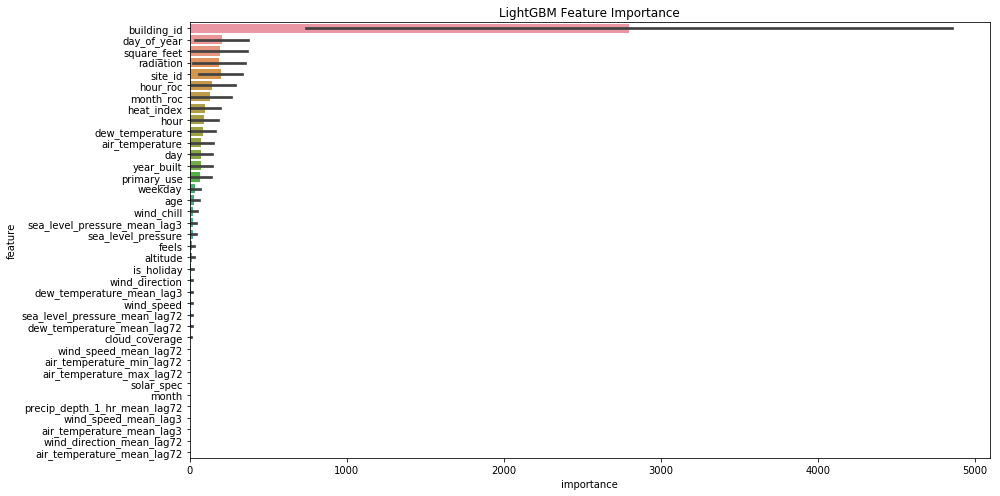

In [5]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [ ]:
'''Before dropping the following columns, we reached:

an rmse_1 of [31]	training's rmse: 0.580533	valid_1's rmse: 0.704328

and rsme_2 of [320]	training's rmse: 0.36866	valid_1's rmse: 0.658466'''

In [3]:
# X_train.drop(['air_temperature_std_lag72','x0_Warehouse/storage', 'x0_Religious worship',
#              'cloud_coverage_mean_lag72','x0_Utility','x0_Parking','x0_Other','x0_Services',
#              'x0_Food sales and service','air_temperature_max_lag3'],axis=1,inplace=True)
# gc.collect()

62

### Prediction

In [5]:
# test = pd.read_pickle('test_encoded.pkl')
test = pd.read_pickle('test_mod2.pkl')
test.shape
gc.collect()

20

In [3]:
# test.drop(['air_temperature_mean_lag72','air_temperature_mean_lag3','wind_direction_mean_lag72',
#              'wind_speed_mean_lag3', 'precip_depth_1_hr_mean_lag72','month', 'day', 'solar_spec', 
#              'air_temperature_max_lag72', 'air_temperature_min_lag72', 'wind_speed_mean_lag72'], axis=1, inplace=True)

In [4]:
# test.drop(['air_temperature_std_lag72','x0_Warehouse/storage', 'x0_Religious worship',
#              'cloud_coverage_mean_lag72','x0_Utility','x0_Parking','x0_Other','x0_Services',
#              'x0_Food sales and service', 'air_temperature_max_lag3'],axis=1,inplace=True)
# gc.collect()

66

In [ ]:
pred = np.expm1(model_half_1.predict(test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

In [ ]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)